In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import astropy.io.ascii
from scipy.optimize import leastsq

# personal import
from sjoert import sync

# local import
import equipartition_functions 
from importlib import reload
reload(equipartition_functions)
from equipartition_functions import *

Doppler factor: 0.7925270806437589


In [6]:
data_rec = astropy.io.ascii.read('./data/at2019dsg_merged.dat', format='fixed_width')

data_rec['eflux_mJy'] = np.clip(data_rec['eflux_mJy'], 0.1*data_rec['flux_mJy'], 1e99) # force errors?

mjd_plot = np.array([58625, 58653, 58703, 58761]) #58818

B_single = np.zeros((len(mjd_plot),2))
B_sum = np.zeros((len(mjd_plot),2))
R_single = np.zeros((len(mjd_plot),2))
R_sum = np.zeros((len(mjd_plot),2))

p0 = [np.log10(0.9*1e16/R0), 60, 0.6, -1.00, 5/3., 2.0]

single-zone:
B=1.063 +/- 0.074 G
d=(1.62 +/- 0.08)x10^16 cm
chi2: 0.9057793196765914
cooling time at 16 GHz (day) 70.84941144554095


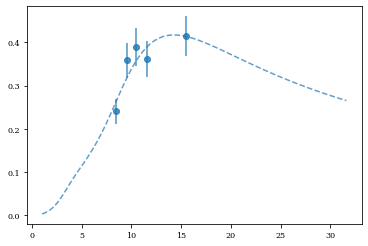

single-zone:
B=0.851 +/- 0.037 G
d=(2.50 +/- 0.08)x10^16 cm
chi2: 2.0074040203548473
cooling time at 16 GHz (day) 99.01881661746036


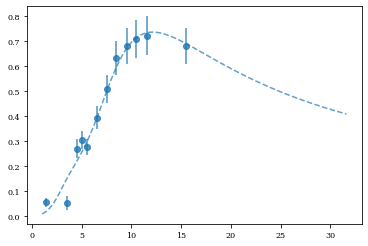

single-zone:
B=0.634 +/- 0.022 G
d=(4.01 +/- 0.12)x10^16 cm
chi2: 0.8310616739534278
cooling time at 16 GHz (day) 153.78753491577493


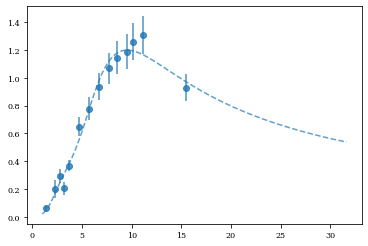

single-zone:
B=0.381 +/- 0.011 G
d=(6.62 +/- 0.20)x10^16 cm
chi2: 2.7241885451176344
cooling time at 16 GHz (day) 330.7366734714139


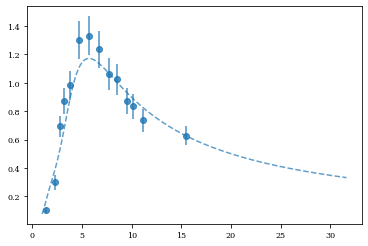

No handles with labels found to put in legend.
No handles with labels found to put in legend.


28 v/c from R_eq     (spherical emitting region): 0.12031678014045108
78 v/c from R_eq     (spherical emitting region): 0.11636063159128583
136 v/c from R_eq     (spherical emitting region): 0.17366757460053872
v/c for neutrino  (spherical emitting region): 5.028248630072264


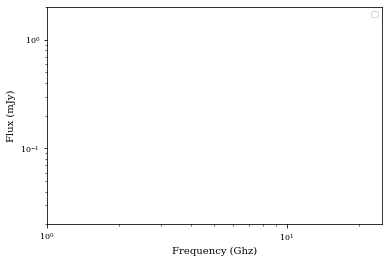


writing:
 ./data/at2019dsg_RB_fit_p2.8.dat


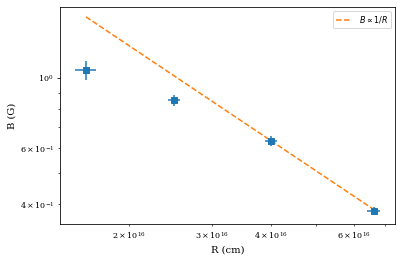

In [7]:
# #ii = argsort(data_rec['mjd'])
# DeltaT = data_rec['mjd'] - min(data_rec['mjd']) + 50 # test!
# lsq_all = leastsq(res_sumtime, p0, (data_rec['nu_GHz']*1e9, DeltaT, data_rec['flux_mJy'], data_rec['eflux_mJy']), full_output=True)
# print (lsq_all[0])


plt.clf()
for i, mjd in enumerate(mjd_plot): 
    it = abs(data_rec['mjd']-mjd)<10
    ii = it * (data_rec['eflux_mJy']>0)

    if sum(ii)>1:
        nu = data_rec[ii]['nu_GHz']
        Fnu = data_rec[ii]['flux_mJy'] - 0.05
        Fnu_err = data_rec[ii]['eflux_mJy'] 

        p0 = [0.1, 1e16]
        lsq = leastsq(res_single, p0, (nu*1e9, Fnu, Fnu_err), full_output=True)
        #p0 = [lsq[0][0], lsq[0][1]] # guess next initial parameters

        if lsq[1] is not None:
            print ('''single-zone:\nB={0:0.3f} +/- {1:0.3f} G\nd=({2:0.2f} +/- {3:0.2f})x10^16 cm'''.format(lsq[0][0],  sqrt(lsq[1][0][0]), lsq[0][1]/1e16, sqrt(lsq[1][1][1])/1e16)		)

            B_single[i,:], R_single[i,:] = (lsq[0][0],  sqrt(lsq[1][0][0])), (lsq[0][1], sqrt(lsq[1][1][1]))
        if len(p0)>2: 
            print ('p={0:0.2f} +/- {1:0.2f}'.format(lsq[0][2],sqrt(lsq[1][2,2])))

        B_single[i,:], R_single[i,:] = (lsq[0][0],  sqrt(lsq[1][0][0])), (lsq[0][1], sqrt(lsq[1][1][1]))

        lbl = sjoert.simtime.mjdtodate(np.mean(data_rec['mjd'][it])).strftime('%y/%m/%d')
        line = plt.errorbar(nu, Fnu,Fnu_err, fmt='o', label=lbl, zorder=10-i, alpha=0.8)
        # ii = it * (data_rec['eflux_mJy']<0)
        # plt.errorbar(data_rec[ii]['nu_GHz'], data_rec[ii]['flux_mJy'], fmt='v', zorder=10-i, alpha=0.8, color=line[0].get_color())

        #plot single-comp model
        xx = np.logspace(9,10.5, 100)
        plt.plot(xx/1e9, fit_single(xx, lsq[0])*1e23*1e3,  '--',alpha=0.7, color=line[0].get_color()) #label=ll1
        ll1=''		

        print ('chi2:', sum(lsq[2]['fvec']**2)/(sum(ii)-len(p0)))
        print ('cooling time at 16 GHz (day)', sync.cooling_extra(lsq[0][0], 16e9)/3600/24)
        #print ('cooling time at 16*(t-300) GHz (day)', sync.cooling_extra(lsq[0][0], 16e9*np.clip(300-t,1,300))/3600/24)
        plt.pause(0.01)


#R0 = 1e15
#p0 = [np.log10(0.9*1e16/R0), 60, 0.6, -1.00, 5/3., 2.0]

plt.legend()

plt.xlim(1.0,25) 
plt.ylim(0.02, 2)
plt.yscale('log')
plt.xscale('log')

for i in [1,2,3]:
    print (mjd_plot[i]-mjd_plot[0], 'v/c from R_eq     (spherical emitting region):', (R_single[i,0]-R_single[i-1,0]) / ((mjd_plot[i]-mjd_plot[i-1])*3600*24) / 3e10) 
print ('v/c for neutrino  (spherical emitting region):', (R_single[3,0]-1e15) / ((5)*3600*24) / 3e10) 

plt.xlabel('Frequency (Ghz)')
plt.ylabel('Flux (mJy)')
plt.legend()
plt.show()
plt.pause(0.01)

plt.savefig('./plots/at2019dsg_radio_singlefit.pdf')
key = input()



plt.clf()
idx = R_single[:,0]>0

plt.errorbar(R_single[idx,0], B_single[idx,0],xerr=R_single[idx,1],yerr=B_single[idx,1], fmt='s')
plt.plot(R_single[:,0], B_single[2,0]*(R_single[:,0]/R_single[2,0])**(-1),'--',label=r'$B\propto 1/R$')
plt.legend()
#plt.errorbar(mjd_plot[idx]-mjd_plot[1], R_single[idx,0],yerr=R_single[idx,1],  fmt='s')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('R (cm)')
plt.ylabel('B (G)')
plt.savefig('./plots/at2019dsg_RB.pdf')

fname = './data/at2019dsg_RB_fit_p{0:0.1f}.dat'.format(p_electron_single)
sjoert.io.writecols(cols=[R_single[:,0],R_single[:,1], B_single[:,0], B_single[:,1]],
    filename=fname,
    names=['R_cm', 'eR_cm', 'B_Gauss', 'eB_Gauss'], delimiter=',')

astropy.io.ascii.write([R_single[:,0],R_single[:,1], B_single[:,0], B_single[:,1]],
    fname, names=['R_cm', 'eR_cm', 'B_Gauss', 'eB_Gauss'],
    formats={'R_cm':'6.3e','eR_cm':'6.3e','B_Gauss':'0.5f', 'eB_Gauss':'0.5f'}, 
    overwrite=True)



# ii = argsort(vla0['DeltaT'])
# print vla0[ii]['DeltaT']
# lsq_all = leastsq(res_sumtime, p0, (vla0[ii]['nu']*1e9, vla0[ii]['DeltaT'], vla0[ii]['Fnu']-VLA_sub[ii], vla0[ii]['Fnu_err']), full_output=True)
# print lsq_all[0]